# Code for simulating the multiple time scale model 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
from itertools import groupby
from matplotlib import cm

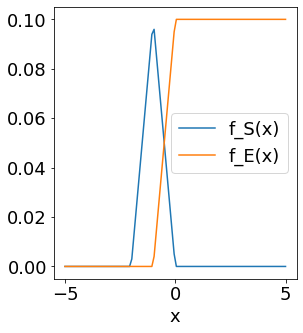

In [5]:
def f1(x, para):
    """
    The f_S function. The rate of learning as a function of S-T, 
    x = S-T
    x_max = the maxium point for learning rate. 
    Write this function in 2 regions
    """
    xm1 = -para["xm"]
    piece1 = - (x - 2*xm1)/xm1
    region1 = (x>=2*xm1)*(x < xm1)
    
    
    piece2 =  x/xm1
    region2 = (x>=xm1 )*(x<=0)
    
    y = para["ym"]*(region1*piece1 + region2*piece2)
    return y
    
def f2(x, para): 
    """
    The f_E function. 
    The rate of execution, also a triangle function. 
    """
    xm2 = para["xm"]
    piece1 = (x +xm2)/xm2
    region1 = (x>= -xm2)*(x<=0)
    
    piece2 = 1
    region2 = (x>0)
    
    #older version for the triangle function
    #piece2 =  -(x - xm2)/xm2
    #region2 = (x>0)*(x<=xm2)
    
    y = para["ym"]*(piece1*region1 + piece2*region2)
    
    return y
    
    
# Plot example of these two functions 
x = np.linspace(-5, 5, 100)

test_para = {"ym": 0.1, "xm": 1}

plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)

plt.plot(x, f1(x, test_para))
plt.plot(x, f2(x, test_para))
plt.xlabel("x")
plt.legend(["f_S(x)", "f_E(x)"])


plt.subplots_adjust(wspace = 0.3)


In [6]:
def count_work_period(time, Plist, simu_para): 
    """
    Find the length of work and rest periods
    """
    workLengthList = []
    restLengthList = []
    workStartList = []
    restStartList = []
    idx = 0
    
    # group by the same consecutive values
    for p, group in groupby(Plist):
        period_idx_length = len(list(group))
        periodLength =period_idx_length*simu_para["deltaT"]
        
        if p == 1: 
            # get length of working periods
            workLengthList.append(periodLength)
            
            # get time for these working periods
            workStartList.append(time[idx])
            
        else: 
            restLengthList.append(periodLength)
            restStartList.append(time[idx])
        
        # keep track of which index it is 
        idx = idx + period_idx_length

    return workLengthList,workStartList, restLengthList, restStartList

In [7]:
"""
Define the dynamics of the system. 
"""

def update_P(P, M, F, Ea):
    """
    update P according to the hysterisis function. Ea is the critical threshold to start working. 
    """
    x = M-F
    if P == 0: 
        if x <= Ea:
            newP = 0
        else: 
            newP = 1
    elif P==1:
        if x >= 0:
            newP = 1
        else: 
            newP = 0
    else: 
        print("Error: wrong P!")
    return newP
    
    
def update_1_timestep(M, F, P, S, A, T, deltaS, deltaA, deltaT, para):
    """
    1 time step of the simulation. 
    """
    # dM/dt in discrete form
    D = para["w"]*deltaS + (1-para["w"])*deltaA
    deltaM = deltaT*(para["C1"]*(para["M0"] - M)*M) + para["C2"]*D
    
    # dF/dt
    if P>0: 
        deltaF = deltaT*(para["C3"]*P)
    elif P==0: 
        deltaF = deltaT*(- para["C4"]*F)
    
    # dS = dS/dt * deltaT. 
    deltaS = P*f1(S - T, para)*deltaT
    
    #dA/dt
    deltaA = P*f2(S - T, para)*deltaT*S
    
    # prescribe Activation threshold. 
    Ea = np.maximum(T-S, 0) 

    # iterate one step
    newP = update_P(P, M, F, Ea)
    newM = M + deltaM
    newF = F + deltaF
    newS = S + deltaS
    newA = A + deltaA
    
    return newM, newF, newP, newS, newA, deltaS, deltaA
    

def get_T(t, T_para, S = np.nan, old_T = np.nan):
    """
    Function that outputs task difficulty 
    """
    
    if T_para["regime"] == "linear": # nonadptive 
        T = t*T_para["lin_slope"] + T_para["T0"]
        
    elif T_para["regime"] == "adaptive_M3": # adaptive
        if np.abs(S - old_T) < T_para["epsilon_2"]: 
            T = old_T + T_para["jump"]        
        else: 
            T = old_T
            
    elif T_para["regime"] == "constant": # constant
        T = T_para["T0"]
        
    else: 
        print("wrong regime in T_para")
        T = np.nan
    
    return T


## Run simulation

In [8]:
def run_simulation(short_para, simu_para,  ICs, T_para):
    
    # Feed the real parameters into the code
    para = {"C1": short_para["C1"], "M0": short_para["M0"], "C2": short_para["C2"], 
        "C3": short_para["C3"], "C4": short_para["C4"], "xm": short_para["xm"], 
        "ym": short_para["ym"], "w" : short_para["w"]}
   
    time = np.linspace(0, simu_para["tmax"], int(simu_para["tmax"]/simu_para["deltaT"]))

    # initialize
    S = ICs["S0"]
    T = ICs["T0"]
    M = ICs["M0"]
    F = ICs["F0"]
    A = ICs["A0"]
    deltaS = ICs["deltaS0"]
    deltaA = ICs["deltaA0"]
    T = ICs["T0"]
    P = ICs["P0"]
    deltaAlist = [deltaA]
    deltaSlist = [deltaA]
    
    Mlist = [ICs["M0"]]
    Flist = [ICs["F0"]]
    Plist = [ICs["P0"]]
    Slist = [ICs["S0"]]
    Alist = [ICs["A0"]]
    Tlist = [T]

    
    # Simulate the model 

    for i, t in enumerate(time[:-1]): 
        # get Task difficulty 
        T = get_T(t,T_para, S, T) 
   
        M, F, P, S, A, deltaS, deltaA = update_1_timestep(M, F, P, S, A, T, deltaS, deltaA, simu_para["deltaT"], para)
        Mlist.append(M)
        Flist.append(F)
        Plist.append(P)
        Slist.append(S)
        Alist.append(A)
        Tlist.append(T)
        deltaAlist.append(deltaA)
        deltaSlist.append(deltaS)
        
    # count work period    
    workLength, workStart, restLength, restStart = count_work_period(time, Plist, simu_para)
    
    # store output 
    out = {"time": time, "M": Mlist, "F": Flist, "P": Plist, "S": Slist, "A": Alist, "T": Tlist, "deltaT": simu_para["deltaT"],
           "workLength": workLength, "workStart": workStart, "restLength":restLength, "restStart": restStart, 
          "deltaA": deltaAlist, "deltaS":deltaSlist}
    return out



## Plot results


In [10]:
def set_x_limit(ax, time, pad = 2): 
    ax.set_xlim([np.min(time)-pad, np.max(time)+pad])

def get_consecutive_idxs(idx):
    """
    Input idx, output list of list that is each sublist is consecutive index
    """
    idxList = []
    for i, item in enumerate(idx): 
        if i == 0: 
            new = [item]
        else: 
            if item == idx[i-1] +1: 
                new.append(item)
            else: 
                idxList.append(new)
                new = [item]
    idxList.append(new)
    return idxList
    

def plot_skill(ax, out, colors, t_start = 0):
    "Plot 1 panel with skill and task difficulty"
    ax.plot(out["time"][t_start:], out["S"][t_start:], "-", color = colors[0])
    ax.plot(out["time"][t_start:], out["T"][t_start:], "--", color = colors[1])
    ax.set_xlabel("Time")
    ax.set_ylabel("Skill and task difficulty")
    time = np.array(out["time"])
    set_x_limit(ax, out["time"])

    
def plot_performance(ax, out, colors, t_start = 0):
    """
    Plot 1 panel for performance
    """
    deltaA = np.array(out["deltaA"])
    #indices = np.where(deltaA > 0)[0]
    idx = np.where(deltaA > 0)[0]
    time = np.array(out["time"])
    
    
    y_array = (1/out["deltaT"])*(np.array(out["S"])*np.array(out["deltaA"]))[idx]
    time_array = time[idx]
    ax.plot(time_array[t_start:], y_array[t_start:], "-", color = colors[6])
    
    ax.set_xlabel("Time")
    ax.set_ylabel("Performance")
    set_x_limit(ax, out["time"])

def plot_M_F(ax, out, colors, t_start = 0):
    """
    Plot 1 panel for motivation and fatigue
    """
    ax.plot(out["time"][t_start:], out["F"][t_start:], "-", color =  colors[3])
    ax.plot(out["time"][t_start:], out["M"][t_start:], ":", color =  colors[2])
    ax.set_xlabel("Time")
    ax.set_ylabel("Motivation and fatigue")
    set_x_limit(ax, out["time"])
    
    
def plot_M(ax, out, colors, t_start = 0):
    """
    Plot 1 panel for motivation 
    """
    ax.plot(out["time"][t_start:], out["M"][t_start:], "-", color =  colors[2])
    ax.set_xlabel("Time")
    ax.set_ylabel("Motivation")
    set_x_limit(ax, out["time"])
    
def plot_F(ax, out, colors, t_start = 0):
    """
    Plot 1 panel for fatigue 
    """
    ax.plot(out["time"][t_start:], out["F"][t_start:], "-", color =  colors[3])
    ax.set_xlabel("Time")
    ax.set_ylabel("Fatigue")
    set_x_limit(ax, out["time"])
    
    
def plot_work_periods(ax, out, colors, truncate_work = 0, truncate_rest = 0, t_start =0 ):
    """
    Plot 1 panel for work and rest periods
    """
    if truncate_work != 0:
        ax.plot(out["workStart"][t_start:truncate_work], out["workLength"][t_start:truncate_work], ".-", color = colors[4])
    else: 
        ax.plot(out["workStart"][t_start:], out["workLength"][t_start:], ".-", color = colors[4])
        
        
    if truncate_rest != 0:
        ax.plot(out["restStart"][t_start:truncate_rest], out["restLength"][t_start:truncate_rest], "^-", color = colors[8])
    else: 
        ax.plot(out["restStart"][t_start:], out["restLength"][t_start:], "^-", color = colors[8])
    
    ax.set_xlabel("Time")
    ax.set_ylabel("Period length")
    set_x_limit(ax, out["time"])
    
    
def plot_1_row(ax, row, out, ifLegend = 0, truncate_work = 0, truncate_rest = 0, t_start = 0):
    """
    Plot 1 row of 4 panels
    """
    colors = plt.get_cmap("Set1").colors

    # first column - S and T. 
    plot_skill(ax[row, 0], out, colors, t_start)
    if ifLegend == 1: 
        ax[row, 0].legend(["S", "T"])
    elif ifLegend == 2: 
        ax[row, 0].legend(["S", "T"], ncol = 2)
        
    # second column, performance
    plot_performance(ax[row, 1], out, colors, t_start)
    if ifLegend == 1:
        ax[row, 1].legend(["S*dA/dt"])
    elif ifLegend == 2: 
        ax[row, 1].legend(["S*dA/dt"], ncol = 2)
        
    # third-fourth column, motivaiton and fatigue in two 
    plot_M(ax[row, 2], out, colors, t_start)
    plot_F(ax[row, 3], out, colors, t_start)

    
    # fifth column, motivaiton and fatigue 
    plot_work_periods(ax[row, 4], out, colors, truncate_work, truncate_rest, t_start)   
    if ifLegend == 1: 
        ax[row, 3].legend(["Work", "Rest"])
    elif ifLegend == 2: 
        ax[row, 3].legend(["Work", "Rest"], ncol = 2)


## Simulate and plot results

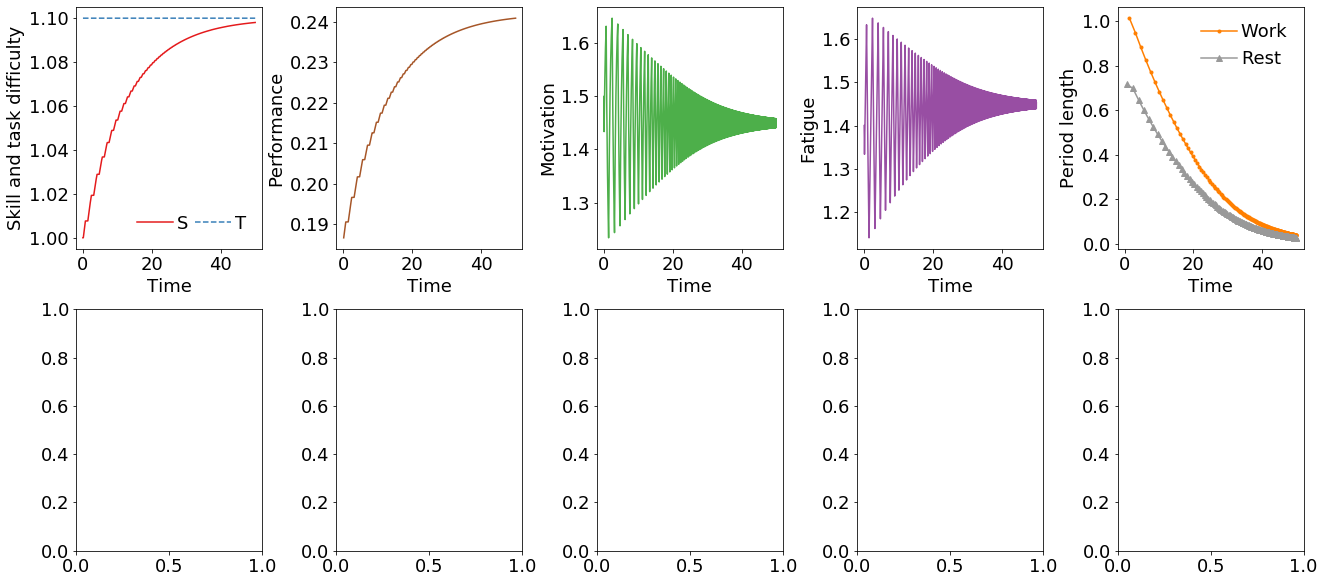

In [11]:

"""
Fig 1 - constant task difficulty 
"""
# ----  Simulation parameters ---- 
# initial condition 
ICs_a = {"M0": 1.5, "F0": 1.4, "P0": 0, "S0": 1, "A0": 0, "T0": 1.1, "deltaS0": 0, "deltaA0": 0}
# constant task difficulty 
T_para_a = {"regime": "constant", "T0": ICs_a["T0"] }


# List of real parameters of the model. 
model_para_a= {"C1": 1, "M0": 1, "C2": 25, "C3": 0.5, "C4": 0.5, "ym": 0.2, "w" : 0.8, "xm": 1.5}

# simulation parameters
simulation_para_a = {"tmax": 50, "deltaT": 0.0001}

# --- Run simulation --- 
out0 = run_simulation(model_para_a, simulation_para_a,  ICs_a, T_para_a) 

# --- Plot results --- 


fig, ax = plt.subplots(figsize = (22, 10), nrows=2, ncols=5)
plot_1_row(ax, 0, out0,  ifLegend = 0, truncate_work= -1, truncate_rest = -1, t_start = 1)

plt.subplots_adjust(wspace = 0.4, hspace = 0.25)

ax[0, 0].legend(["S", "T"], ncol = 2, columnspacing = 0.4, handletextpad=0.2, loc = 4, frameon=False)
#ax[0, 1].legend(["S*dA/dt"], handletextpad=0.2, loc = 4, frameon=False)
#ax[0, 2].legend(["F", "M"], ncol = 2, columnspacing = 0.4, handletextpad=0.2, loc = 4, frameon=False)
ax[0, 4].legend(["Work", "Rest"], ncol = 1,columnspacing = 0.4, handletextpad=0.2, loc = 1, frameon=False)


plt.savefig("one_row_results")

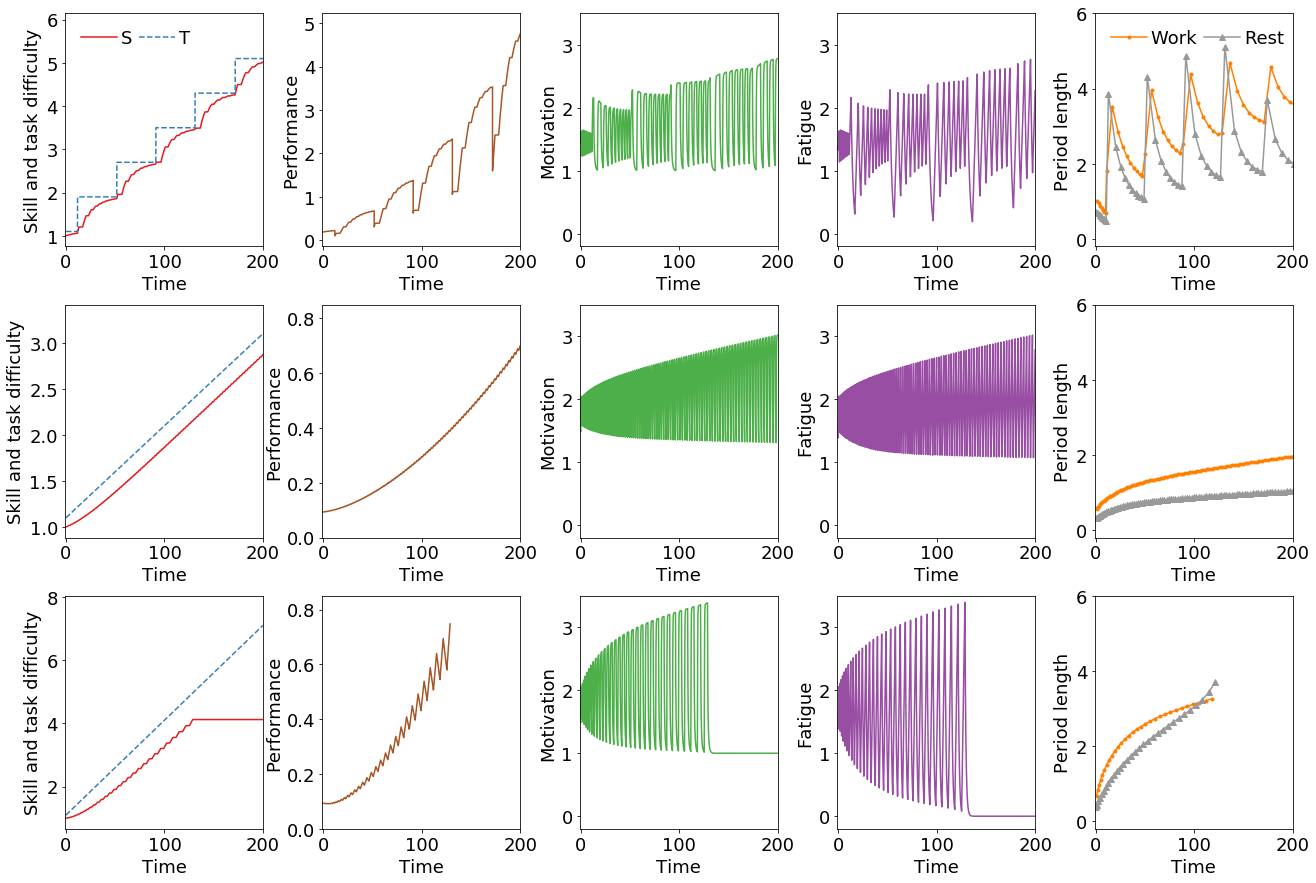

In [12]:

"""
Fig 2 - 3 row for 3 regimes
"""
 
#---- linear task difficulties ---- 
# initial condition 
ICs_a = {"M0": 1.5, "F0": 1.4, "P0": 0, "S0": 1, "A0": 0, "T0": 1.1, "deltaS0": 0, "deltaA0": 0}

# List of real parameters of the model. 
model_para_lin= {"C1": 1, "M0": 1, "C2": 100, "C3": 1, "C4": 1, "ym": 0.1, "w" : 0.8, "xm": 1.5}


T_para_lin_slow = {"regime": "linear", "lin_slope": 0.01, "T0":ICs_a["T0"] } # M2: task increases slowly and linearly . 
T_para_lin_fast = {"regime": "linear", "lin_slope": 0.03, "T0":ICs_a["T0"]} # M1: task increases fast

simulation_para_lin_slow = {"tmax": 220, "deltaT": 0.005}

simulation_para_lin_fast = {"tmax": 220, "deltaT": 0.005}



# --- Adaptive task difficulties ---- 
model_para_adaptive= {"C1": 1, "M0": 1, "C2": 25, "C3": 0.5, "C4": 0.5, "ym": 0.2, "w" : 0.8, "xm": 1.5}


simulation_para_adaptive = {"tmax":220, "deltaT": 0.001}
T_para_adaptive = {"regime": "adaptive_M3", "epsilon_2": 0.05*0.8, "jump": 0.8} # M3, adaptive with discrete jumps. 
#NOTE: Epsilon is chosen so that is depends on w. Epsolon = 0.05*w

#--- simulate the 3 trials
out_lin_slow = run_simulation(model_para_lin, simulation_para_lin_slow,  ICs_a, T_para_lin_slow) 
out_lin_fast = run_simulation(model_para_lin, simulation_para_lin_fast,  ICs_a, T_para_lin_fast)
out_adaptive = run_simulation(model_para_adaptive, simulation_para_adaptive,  ICs_a, T_para_adaptive)



# --- Plot results --- 
MF_min = -0.2
MF_max = 3.5

WR_min = -0.2
WR_max = 6
tmin = -1
tmax = 200

fig, ax = plt.subplots(figsize = (22, 15), nrows=3, ncols=5)
plot_1_row(ax, 0, out_adaptive,  ifLegend = 0, truncate_work= -1, truncate_rest = -1, t_start = 1)


plot_1_row(ax, 1, out_lin_slow,  ifLegend = 0, truncate_work= -1, truncate_rest = -1, t_start = 1)
plot_1_row(ax, 2, out_lin_fast,  ifLegend = 0, truncate_work= -1, truncate_rest = -1, t_start = 1)

for i in range(3): 
    ax[i, 2].set_ylim([MF_min, MF_max])
    ax[i, 3].set_ylim([MF_min, MF_max])

for i in range(3): 
    ax[i, 4].set_ylim([WR_min, WR_max])

for i in range(3): 
    for j in range(5):
        ax[i, j].set_xlim([tmin, tmax])
    
    

    
Pmax = 0.85
ax[1, 1].set_ylim([0, Pmax])    
ax[2, 1].set_ylim([0, Pmax])    


plt.subplots_adjust(wspace = 0.3, hspace = 0.25)

ax[0, 0].legend(["S", "T"], ncol = 2, columnspacing = 0.4, handletextpad=0.2, loc = 2, frameon=False)
#ax[0, 1].legend(["S*dA/dt"], handletextpad=0.2, loc = 2, frameon=False)
#ax[0, 2].legend(["F", "M"], ncol = 2, columnspacing = 0.4, handletextpad=0.2, loc = 2, frameon=False)
ax[0, 4].legend(["Work", "Rest"], ncol = 2,columnspacing = 0.4, handletextpad=0.2, loc = 2, frameon=False)


plt.savefig("three_row_results.pdf")

## Generate plot comparing individuals motivated by skill and performance. 
epsilon = min epsilon + slope * w


In [14]:
def adaptive_epsilon(w, minEps = 0.001, slope = 0.05):
    return minEps + slope*w

# model parameters
model_para_adaptive_small_w= {"C1": 1, "M0": 1, "C2": 25, "C3": 1, "C4": 1, "ym": 0.1, "w" : 0, "xm": 1.5}
model_para_adaptive_large_w= {"C1": 1, "M0": 1, "C2": 25, "C3": 1, "C4": 1, "ym": 0.1, "w" : 1, "xm": 1.5}

# adaptive task difficulty with discrete jumps
T_para_adaptive_large_w = {"regime": "adaptive_M3", "epsilon_2": adaptive_epsilon(model_para_adaptive_large_w["w"]), "jump": 0.8}  
T_para_adaptive_small_w = {"regime": "adaptive_M3", "epsilon_2": adaptive_epsilon(model_para_adaptive_small_w["w"]), "jump": 0.8} 
simulation_para_adaptive = {"tmax":400, "deltaT": 0.005}

# run simulation
out_adaptive_small_w =run_simulation(model_para_adaptive_small_w, simulation_para_adaptive,  ICs_a, T_para_adaptive_small_w)
out_adaptive_large_w =run_simulation(model_para_adaptive_large_w, simulation_para_adaptive,  ICs_a, T_para_adaptive_large_w)



### Plot skill and and performance on the same plot. 

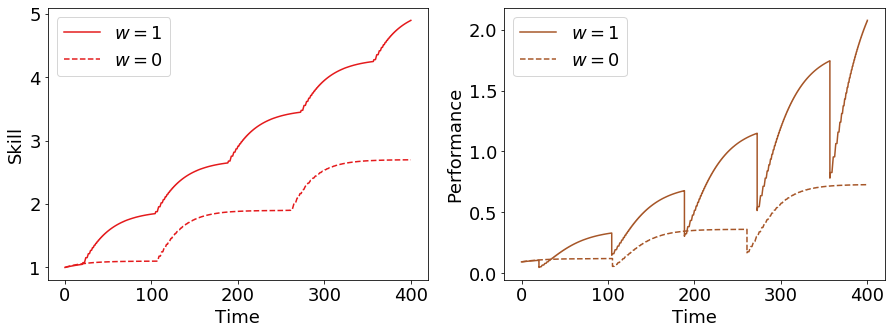

In [15]:
def compare_trials(ax, outlist, colorlist = range(10), lineList = ["-", "--"]):
    colors = plt.get_cmap("Set1").colors

    for i, out in enumerate(outlist):
        # Plot skill levle 
        ax[0].plot(out["time"], out["S"], lineList[i], color = colors[0])
        
        # Plot performance 
        deltaA = np.array(out["deltaA"])
        idx = np.where(deltaA > 0)[0]
        time = np.array(out["time"])
        y_array = (1/out["deltaT"])*(np.array(out["S"])*np.array(out["deltaA"]))[idx]
        time_array = time[idx]
        ax[1].plot(time_array, y_array, lineList[i], color = colors[6])
        
    ax[0].set_xlabel("Time")
    ax[0].set_ylabel("Skill")
    ax[1].set_xlabel("Time")
    ax[1].set_ylabel("Performance")
    
    
fig, ax = plt.subplots(figsize = (15, 5), nrows=1, ncols=2)
compare_trials(ax, [out_adaptive_large_w, out_adaptive_small_w])
plt.subplots_adjust(wspace = 0.2)
ax[0].legend(["$w = 1$", "$w = 0$"])
ax[1].legend(["$w = 1$", "$w = 0$"])


plt.savefig("stair_case_w_comparisons.pdf")